# 개요
* 참여중인 데이터 엔지니어링 스터디에서 배우는 내용 정리
  * 데이터 수집, 정제 : pyspark, airflow
  * 저장 : elasticsearch
  * 시각화 : kibana

# 2주차 과제리뷰

## 선택한 데이터셋 정제할 방법 고민(gh archive)

### json 읽고 스키마 확인하기
  ```python
  github = spark.read.json("../data/*.json.gz")
  github.printSchema()
  >>> root
  |-- actor: struct (nullable = true)
  |    |-- avatar_url: string (nullable = true)
  |    |-- display_login: string (nullable = true)
  |    |-- gravatar_id: string (nullable = true)
  |    |-- id: long (nullable = true)
  |    |-- login: string (nullable = true)
  |    |-- url: string (nullable = true)
  |-- created_at: string (nullable = true)
  ```

### 스키마 지정하기
```python
from pyspark.sql.types import StructType, StructField, StringType, LongType
import pyspark.sql.functions as F

actor_schema = StructType([
    StructField('login', StringType(), True),
    StructField('url', StringType(), True)
])

payload_schema = StructType([
    StructField('repository_id', LongType(), True),
    StructField('size', LongType(), True),
    StructField('distinct_size', LongType(), True),
    StructField('message', StringType(), True)
])

repo_schema = StructType([
    StructField('name', StringType(), True),
    StructField('url', StringType(), True)
])
```

* **데이터를 보기에 nested json인데, 타입이 struct가 아니라 string이 나온 경우**
  * **Spark가 inference를 하지 못했을 상황으로, 스키마 정의해주어야 함**
  ```python
  new_df = github.withColumn('actor_json', F.from_json('actor', actor_schema)) \
              .select('created_at', 'id', 'payload', 'type', 'actor_json.*', 'repo')
  ```
    * `F.from_json('actor', actor_schema)`으로 필요한 데이터만 가져오게 됨
    * .select문의 `actor_json.*`으로, **actor_json.login**과 **actor_json.url**을 불러옴

    
* 데이터가 잘 읽혔다면 withColumn을 사용할 필요없이 바로 .select로 쿼리가능
  * actor_json.login와 같은 경우 `F.col(actor_json.login).alias('actor_url')`과 같이 컬럼명 지정 가능
    * ambiguous 관련 오류를 방지할 수 있다
  ```python
  new_df = github.select('created_at', 'id', 'payload', F.col(actor_json.login).alias('actor_url'))
  ```

### 데이터 읽고 정제하기
* **filter** 예시
```python
new_df = new_df.filter(col("login") != "github-actions[bot]")
```

* **regexp_replace**(정규식 사용) 예시
```python
new_df = new_df.withColumn('created_at', F.trim(F.regexp_replace(new_df.created_at, "[TZ]", " ")))
```

* **to_timestamp** 예시
```python
new_df = new_df.withColumn('created_dt', F.to_timestamp(new_df.created_at, 'yyyy-MM-dd HH:mm:ss'))
```

* **UDF(UserDefineFunction)** 예시
  * `F.udf(function, type)`형식으로 생성, F.Col을 사용해서 적용
```python
def check_repo_name(name):
    sp = name.split("/")
    if not sp:
        return name
    else:
        return sp[-1]
    
udf_check_repo_name = F.udf(check_repo_name, StringType())

new_df = new_df.withColumn('repo_name', udf_check_repo_name(F.col('name')))
```

### 기타 참고
* Pyspark의 EOF에러는 메모리 문제일 수 있음

* Window function
  * 예시 : 전체가 아닌 repo_name을 기준으로 임시window(파티션)을 생성하여 size기준으로 내림차순
  ```python
  from pyspark.sql.window import Window
  from pyspark.sql.functions import col, row_number

  w = Window.partitionBy("repo_name").orderBy(F.desc(col("size")))
  new_df.withColumn("row", row_number().over(w)) \
        .filter(col("row") == 1).drop("row") \
        .count()
  ```
    * row_number().over(w) : w에 할당된 윈도우 끼리만 row_number를 매김
    * .filter(col("row") == 1).drop("row") : (내림차순 후) 첫째행만 filter한다 + 이후 필요없어진 row컬럼을 drop
    
* Elastic search 사용을 대비해, id를 남기는 것이 좋음
  * 남기지 않더라도 ES에서 지정해 줌

# 3주차 수업정리

## Shuffle & Partition

* Partitioning(파티셔닝)
  * (Spark는 분산처리를 위한 플랫폼이며) 파티셔닝은 데이터를 여러 클러스터 노드로 분할하는 알고리즘
  * Partition(파티션) : 데이터의 조각, 데이터 처리의 단위 (**데이터 자체가 아니고 meta정보**)
  * 파티션 개수 : RDD변환 연산을 실행할 태스크 개수와 동일
  * **주의할 점**
    * 태스크 수가 적으면 클러스터를 충분히 활용하지 못함
      * 노드가 100개인데 파티션이 2개라면, 태스크가 2개이므로 98개의 노드가 놀게 됨
    * 태스크가 처리할 데이터 분량이 (너무크면) 메모리 리소스를 초과할 수 있다
      * 데이터가 큰데, 파티션이 하나라면 메모리 리소스를 초과할 수 있다.
        (Spark는 기본적으로 데이터를 메모리에 올려서 처리하므로, **적절히 나누는게 중요**)
    * 파티션의 수를 정하는데 정답은 없음. `처음 추천세팅`값은 아래와 같음
      * `클러스터 코어 개수보다 3~4배 더 많은 양으로 파티션 개수 설정`
      * 실험하며 태스크 관리작업에 병목이 없도록 결정(변경)
        * 느리다면 파티션을 나눠 많은 클러스터가 사용되도록 (병렬처리 갯수를 늘리도록)
        * 메모리 부족 등으로 태스크가 죽는다면, 파티션의 크기를 줄인다
<br>

* Partitioner(파티셔너)
  * 파티셔닝을 담당하는 객체, 여러 구현체가 있음
  * 파티션의 수를 부여하지 않아도, **기본 파티션 개수**가 있음
    * 초기 **SpartContext생성옵션**에서 지정가능 (spark.default.parallelism)
  * HashPartitioner (디폴트 파티셔너, 해싱을 해서 나눔)
    * 파티션의 수(numberOfPartitions)를 부여하면, 해싱을 하여 partitionIndex를 만들어줌
  * RangePartitioner
    * 정렬된 RDD를 범위 간격으로 분할 (직접 사용하는 경우가 많지 않음. 사용하기 전에 정렬을 해야하기 때문)
  * User Defined Partitioner
    * 직접 구현, pair RDD에서만 사용가능
    * 구현해야하는 구현체는, patitioner라는 구현체를 상속받아서 / 2가지 function을 overide해야 함
      * numPartitions : 파티션의 수를 리턴
      * getPartition(key) : key를 받아서, index를 리턴
<br>

* Partition(파티션)
  * 처리하고자 하는 데이터가 분할할 수 없는 파일인 경우 무용지물
  * 처리대상 데이터의 저장 방식(포맷, 압축 등)은 (같은 파티셔너를 쓰더라도)작업 성능에 영향을 준다
    * 가지고 있는 데이터가 어떤지도 성능에 영향을 미칠 수 있다
<br>

* Partition관련 파라미터
  * **spark.default.parallelism(많이 사용)**
  * spark.files.maxPartitionBytes
  * spark.files.openCostInBytes
  * spark.sql.files.minPartitionNum
  * spark.sql.leafNodeDefaultParallelism
  * **spark.sql.shuffle.partitions(많이 사용)**
  * spark.sql.adaptive.advisoryPartitionSizeInBytes (spark.sql.adaptive.enabled)
<br>

* Shuffling(셔플링)
  * 파티션 간의 물리적 데이터 이동 (Join, reduce와 같이 데이터의 이동이 일어나는 경우)
  * 새로운 RDD파티션을 만들기 위해 여러 파티션의 데이터를 합칠 때 발생
  * 셔플링은 2가지 과정을 거쳐 일어남
    * 디스크에 중간 병합 결과를 저장하고, 이를 읽어들여 병합
    * 셔플링할 데이터를 네트워크로 전송하는 비용(Disk I/O) 발생 
<br>

* Shuffling 발생조건
  * 파티셔너를 명시적으로 변경하는 경우
    * (디폴트 파티셔닝이 되어있었으므로)파티션을 새롭게 만드므로 반드시 발생
    * HashPartitioner의 개수를 변경하는 경우도 (다시 해싱하며 파티션인덱스가 바뀌므로) 발생
  * aggregate와 같은 셔플링이 발생하는 API
    * 예시 : rdd.aggregateByKey(zero, seqFunc, comboFunc, 100) [파티션의 기준이 key가 되는 것]
  * 파티셔너를 제거하는 경우
    * map, flatMap은 RDD의 partitioner를 제거한다
      * map만 했을 때는 파티션을 새로 만들지는 않지만, **모든 데이터를 순회했기때문에 제거한 것에 해당**
      * **map을 한 뒤에, 다른 변환을 연이어 사용하게되면 셔플링이 발생함** (이미 제거된 것에서 파티션을 만드는 것이 됨)
        ```python
        rdd.map(lambda x: (x, x*x)).map(swap).count()
        rdd.map(lambda x: (x, x*x)).reduceByKey(lambda v1, v2: v1+v2).count()
        ```
      * map, flatMap 변환 연산자 뒤에 사용하면 셔플링이 발생하는 연산자
        ```
        aggregateByKey, foldByKey, reduceByKey, groupByKey, join, 
        leftOuterJoin, rightOuterJoin, fullOuterJoin, subtractByKey
        ```
      * 셔플링이 발생하는 function
        * coalesce는 노드간 데이터 이동없이 파티션 수만 줄어드는 알고리즘이 되어있지만, 'shuffle=True'적용시는 발생
        ```
        subtract, intersection, groupWith
        sortByKey
        partitionBy, coalesce (shuffle=True)
        ```
    * pairRDD의 경우, map대신 mapValues를 사용하면 셔플링으로부터 자유로움
<br>

* Shuffling Optimization
  * 셔플링이 발생한다고 아예 안쓸 수는 없으며, Optimization방법을 고민
  * spark.shuffle.service.enabled = true
  * spark.shuffle.manager : sort-based shuffling(파일을 적게쓰고 메모리를 효율적으로 사용)
    * hash-based shuffling보다 효율적
  * spark.shuffle.spill.compress: 디스크로 내보낼 데이터의 압축 여부 (아주 조금 도움)
  * spark.shuffle.memoryFraction: 셔플링에 쓸 메모리 임계치
    * 낮추면, 큰 데이터인 경우 디스크에도 썼다 올리면서 느려지지만 죽지 않음 
  * spark.shuffle.spill: 셔플링에 쓸 메모리를 제한할지 여부
  * spark.shuffle.compress: 중간 파일의 압축 여부
  * spark.shuffle.spill.batchSize: 데이터 디스크로 보낼 때 직렬화, 역직렬화할 객체 개수
    * 직렬화할 Batch단위 설정
  * spark.shuffle.service.port: 외부 셔플링 서비스 활성화할 경우 서비스가 사용할 포트
    * 셔플링이 무거운 작업이므로, 효율적으로 할 수 있게 도와주는 3rd파티 서비스(어플리케이션)이 있음
<br>

* 파티션 변경 이유
  * 작업 부하를 효과적으로 분산
  * 메모리 문제 방지
  * (많은 케이스)특정 데이터들이 같은 파티션에 속해야 하는 경우
    * 예를 들어, 같은 group-name을 가진 데이터는 동시 처리되지 않아야 하는 경우
    * API호출을 특정 시간내 일정 횟수만 호출해야하는 경우
    * 같은 파티션이라면 병렬이 아닌 순차처리
    * `repartition(partitionExprs=group-name)`을 사용해 컬럼 값이 같은 데이터는 같은 파티션으로
      * skew발생할 수 있음 (특정 노드가 놀아서 비효율적일 순 있으나, 필요한 경우이므로 감안)
  * 파티션 변경 명령어
    * partitionBy
    * coalesce
    * repartition 
    * repartitionAndSortWithinPartition
<br>

* 파티션 단위 연산
  * mapPartition : (map과 달리) 전체 데이터가 아닌 파티션 별로 iteration을 할 수 있다
    * iterator를 리턴하므로, 한번 더 순회해주어야 함(함수 시그니처에 주의)
    * 위의 예시였던 같은 group-name을 한 파티션에 넣은 경우에도, 파티션 내의 group-name을 확인 후 작업하도록 할 수 있음
    * 특정 파티션 작업을 완료한 후, system.gc(가비지콜렉팅)을 해주며 메모리 관리도 가능
  * mapPartitionsWithIndex : iterator와 함께 index도 받을 수 있다
    * n번째 파티션마다 다른 처리 가능
<br>

* Shuffling 파라미터
  * maxReqsInFlight:  Request가 동시에 얼마나 갈지 설정
  * memory.fraction: memory 중 일부만 사용하고 나머지는 hfile 로 disk 에 내림 
  * maxReqs : (동시에X, 전체) Request 건수 설정
  * executor.memoryOverhead

## SparkSQL

* SparkSQL
  * SQL명령을 작성하면 Dataframe연산으로 변환한다
    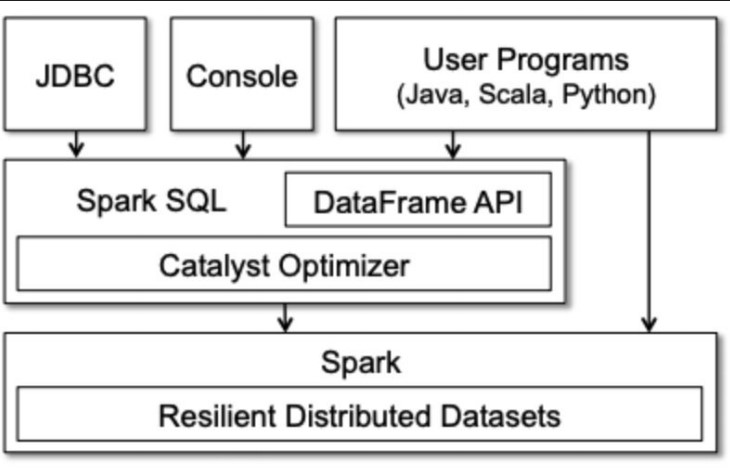

* UDF (사용자 정의 함수, pyspark.sql.functions.udf)
  * UDF 코드예시 
    ```python
    from pyspark.sql.functions import udf
    from pyspark.sql.types import IntegerType

    slen = udf(lambda s: len(s), IntegerType()) 
    @udf
    def to_upper(s):
        if s is not None: 
            return s.upper()

    @udf(returnType=IntegerType()) 
    def add_one(x):
        if x is not None: 
            return x + 1

    df = spark.createDataFrame([(1, "John Doe", 21)], ("id", "name", "age"))
    df.select(slen("name").alias("slen(name)"), to_upper("name"), add_one("age")).show()
    ```
<br>

* Grouping
  * Groupby
  * rollup : 다양한 컬럼을 그룹화 키로 설정 가능(심화된 버전의 groupby)
    * 그룹별 결과 뿐 아니라 총 집계도 따로 해 줌
  * cube : 모든 차원에 대해 작업 수행(rollup의 고차원적인 사용)
    * 테이블에 있는 모든 정보를 빠르고 쉽게 조회할 수 있는 요약정보 테이블 생성
<br>

* Window(pyspark.sql.Window)
  * window코드예시
    ```python
    import pyspark.sql.Window

    window = Window.partitionBy('platform').orderBy(desc(col("Quantity"))) 

    f.rank().over(window) # partitionBy에서 지정한 platform끼리 function.rank를 매김

    Window.currentRow 
    Window.rangeBetween
    ```

* Hive
  * 실습시 만들었던 temporary테이블은 SparkContext가 내려가면 사라지며, 저장하고 싶다면 Hive를 사용
  * Hive는 (HDFS와 HDFS와 호환되는)파일시스템에 보관된 데이터에 대한 분석 툴
  * SQL과 유사한 쿼리 언어인 HiveQL제공
  * 쿼리를 Spark, MapReduce, Tez작업으로 변환
  * Spark에 SparkSQL커맨드라인이 있듯이, beeline이라는 H(ive)QL 실행가능한 커맨드라인 인터페이스 내장
  * ACID 트랜잭션을 지원
  * 작동 
    - 실행 계획을 생성하고 SQL 쿼리를 처리하기 위한 YARN 작업을 자동 생성 
    - 분산형 어플리케이션으로 작동
    - 작업 결과를 어플리케이션이나 HDFS 로 반환
<br>

* Table Catalog
  * Spark가 저장하는 등록된 Dataframe테이블(임시로 생성하는 등록된 Temporary Dataframe)
  * 단순한 in-memory Map으로 구현되어, **SparkContext를 내리면 함께 내려감**
  * Hive가 enable된 경우는 영구적으로 하이브(메타스토어)에 저장
    * Hive enable과 함께, **Hive 어플리케이션을 실행해 나오는 Hive마스터 주소**를 Spark옵션에 작성해주어야 함
    * `Sparksession`을 만들 때, `Hive.enable=True`, `Hive마스터 주소`를 함께 넣어야 함 
  * 임시 vs 영구 여부에 따른 차이
    * 테이블 임시등록(임시 Table Catalog) : `spark.createOrReplaceTempView`
    * 테이블 영구등록(영구 Hive) : `df.write.saveAsTable`
  * **Table catalog도 Hive도 각자의 메타스토어에 저장됨**
<br>

* SparkSQL실행방법
  * 테이블 등록 후 쿼리 실행 : spark.sql(“select * FROM table”)
  * Spark SQL Shell(커맨드라인) : bin/spark-sql 실행 후 쿼리
    * 메타스토어에 lock을 걸기 때문에 기존의 Spark shell은 중지 필요 (2개 동시 실행은 안됨)
  * JDBC서버에서 실행 : Thrift server enable을 해둔 후, (중간다리역할을 하는) Thrift server로 쿼리를 JDBC서버로 보낼 수 있음

## Optimization

* Spark job을 Optimize 하기(정답이 있는 부분은 아님)
  * 아래의 항목을 단계별로 확인(**앞쪽 항목일수록 중요**, 항목들을 반복/순회하며 최적화)
    * **Data확인**
        * compression방식, 데이터 포맷(에 따라 파티셔너가 동작하지 않을 수 있음)
        * 분할 불가능한 데이터
        * 특정 raw에 이상한 값이 있는 경우 (처리 불가한 상태가 될 수 있음)
    * **Spark DAG확인**
        * (실행순서 조정 등을 통해 최적화해주는)Spark의 카탈리스트 엔진(옵티마이저)
        * 카탈리스트 옵티마이저가 작업을 끝내면 DAG(Directed acyclic graph)형태로 나옴
        * 트리모양의 DAG가, 내가 원하는 방향으로 작성되었는지 확인(내가 코드를 원하는 SparkOperation으로 전환했는지)
        * 리소스 확인
        * 디스크, 메모리 부족 여부
            * 갑자기 죽는 경우 메모리가 부족하거나, 메타스토어 등에서 lock을 잡아 강제종료된 경우
    * **User application 확인**
        * 내가 작성한 Spark코드의 이상 여부
  * 중간마다 cache와 checkpoint를 활용해 불필요한 반복을 줄임
<br>

* Optimization Options
  * 나의 상황에 따라 drvier와 executor의 메모리 등을 조정
    * 느린 이유가 print작업이 많아서라면 driver메모리
    * 느린 이유가 join작업에서 dataframe이 크다면 executor메모리
  * Yarn cluster기준의 옵션 샘플1
    * 단순참고)하단의 driver/executor메모리(8G)와 코어(4)옵션은 페타바이트 수준의 데이터를 다룰 정도의 옵션
    ```
    <path-to-spark-submit>/spark-submit \
        --class <project.class.path> \
        --name HelloWorld \    # job name지정
        --master yarn \        # master(현재 실습기준으로는 local)
        --deploy-mode client \
        --driver-cores 4 \     # optimization옵션에 해당
        --driver-memory 8g \   # optimization옵션에 해당
        --num-executors 100 \  # optimization옵션에 해당
        --executor-cores 4 \   # optimization옵션에 해당 (병렬처리를 얼마나 많이 할지)
        --executor-memory 8g \ # optimization옵션에 해당
        --conf spark.logConf=true \ 
        <jar file path> \
        args=value
    ```
  * Yarn cluster기준의 옵션 샘플2
    * 사용하는 클러스터에 맞는 옵션 사용
      * 실습중인 gh archive데이터도 규모에 따라 메모리가 터질 수 있으니 바꿔보기
    ```
    spark-submit
      --driver-cores 1      # 실습시 바꿔볼 수 있는 부분
      --driver-memory 1g    # 실습시 바꿔볼 수 있는 부분
      --num-executors 1     # 실습시 바꿔볼 수 있는 부분
      --executor-cores 1    # 실습시 바꿔볼 수 있는 부분
      --executor-memory 1g  # 실습시 바꿔볼 수 있는 부분
      --conf spark.yarn.am.cores=1
      --conf spark.yarn.am.memory=1g
      --conf spark.yarn.am.memoryOverhead=1g
      --conf spark.driver.memoryOverhead=1g     # 실습시 바꿔볼 수 있는 부분
      --conf spark.executor.memoryOverhead=1g   # 실습시 바꿔볼 수 있는 부분
      --conf spark.sql.shuffle.partitions=1 
    ```
<br>

* Catalyst Engine
  * Dataframe DSL 과 SQL 표현식을 하위 레벨의 RDD 연산으로 변환한다
  * Dataframe function이 pyspark.sql과 같이 sql패키지에 있던 이유
    * 카탈리스트 엔진이 SQL표현식을 하위 레벨의 RDD연산으로 변환하기 때문
  * 실행순서
    * Expression(SQL 등 작성) → Parsed Logical Plan <br>
      →  Analyzed Logical Plan →  Optimized Logical Plan <br>
      → Physical Plan
  * 기본 구조 : 노드로 구성된 트리 (DAG구조)
    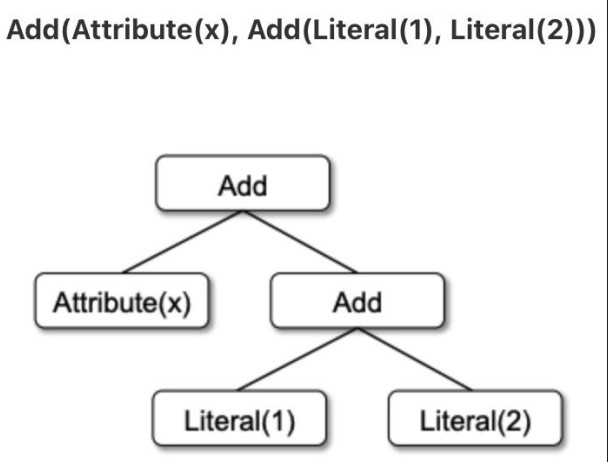
<br>

* Tungsten Project
  * spark 1.5 와 함께 공개, 메모리 관리 방식 혁신
    * 객체를 이진수로 인코딩하고 메모리에서 직접 참조 
    * on-heap: 이진 인코딩 객체를 long 배열에 저장
    * off-heap: spark 가 메모리 주소 직접 할당하고 해제 
    * 텅스텐 셔플링 매니저: 이진 인코딩 기반 정렬 셔플링
<br>

* Spark DAG 확인방법 3가지
  * Explain method : dataframe`.explain(True)`와 같이 작성하여 실행
    * Parsed Logical Plan부터 Physical Plan까지 프린트 됨
  * Spark UI의 `SQL`탭에서 확인 가능
  * 실행중인 Job목록에서, `+버튼`(datails)을 누르면 Plan 확인 가능
<br>

* DAG(Logical/Physical Plan) 샘플화면
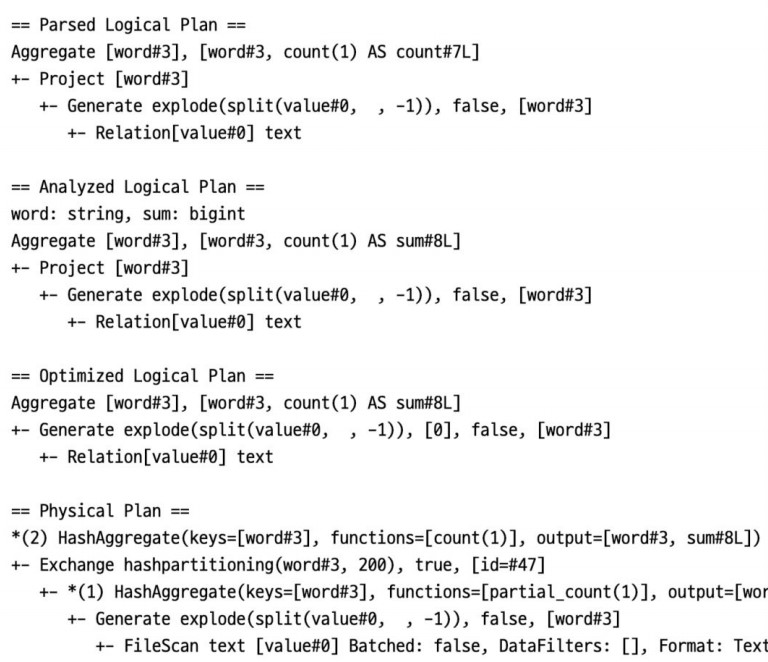
<br>

* Partitions Statistics
  * 파티션 별로 각 컬럼의 통계(lower bound, upper bound, NULL count 등) 활용
    * 예를 들어, filtering으로 30보다 작은 것을 찾을 때, lower bound가 40이면 파티션을 건너뛰어 작업성능 최적화
  * 이러한 컬럼 통계는 dataframe을 메모리에 캐시하면 자동으로 계산
    * cache를 불필요한 계산을 막아 성능이 오르는 부분 외에, 컬럼 통계 반영으로 성능이 오르는 부분도 있음
<br>

* Partition Pruning
  * (얻고자 하는 데이터를 포함하지 않은)파티션을 제외하고 읽는 것
  * Static Partition Pruning(정적 프루닝)
    * join이 발생하는 상황에서는 정적으로 pruning하기 어려움(큰 DB를 Join하여 optimization효과 기대 어려움)
  * Dynamic Partition Pruning(동적 프루닝)
    * SQL 논리계획, 물리적 실행계획 변경 (필터를 삽입해준다)
<br>

## Advanced Topics

* 3rd-party 어플리케이션
  * Zepplin : notebook (Jupyter와 같은 역할)
    * visualization이나 Spark 백엔드 사용 등이 편리함
    * Search interpreters에서 Spark를 검색하여, hostname이나 포트(실습환경기준 sparkmaster:7077)입력하여 노트북 사용 설정
      * Jupyter는 이러한 설정을 해도, 별도의 옵션을 넣어야해서 상대적으로 번거로움
    * 링크 : https://zeppelin.apache.org/docs/0.11.1/quickstart/install.html
  * MLLib
    * 머신러닝 알고리즘들을 분산 방식으로 구현한 라이브러리
    * 알고리즘의 종류가 많지 않음(꾸준히 늘어나고 있음)
    * 기본적인 알고리즘은 있음(kmeans, decision tree, random forest, logistics regresson 등)
    * **지속적으로 늘어나는 데이터셋에 머신러닝을 적용할 수 있도록 지원**
  * Spark Streaming
    * 실시간성 데이터에 사용
    * Spark는 기본적으로 배치 처리를 지향
    * Spark Streaming은 mini-batch를 사용
      * 특정 시간 간격 내에 유입된 데이터 블록을 RDD로 구성
      * 즉 완벽한 스트리밍은 아님. 시간간격은 사용자가 설정
    * Spark Streaming Job으로 유입할 수 있는 외부 데이터 시스템
      * 단순 파일 시스템
      * TCP/IP 접속
      * kafka, flume 등 분산 시스템 (kafka + Spark stream 조합은 실무에서 많이 쓰임)
    * 각 데이터 소스별로 receiver를 제공하므로, kafka나 IP 등에 맞춰 맞는 receiver사용
    * 사용방법
      * Spark Context와 Duration(미니배치를 생성할 시간간격)을 Streaming Context에 전달
      * sc.textFile() → sc.textFileStream()
        * 새로운 배치가 인입되면서 state가 변경된다
        * Stream용으로 mapWithState, updateStateByKey 등의 API사용
  * GraphX
    * Spark의 그래프처리 API
      * 그래프로 데이터를 구성하여 그래프 알고리즘을 적용하고자 하는 경우
      * VertexRDD, EdgeRDD를 구성해, Graph오브젝트[Graph(vertices, edges)]에 넣어 Graph데이터 구조를 만듦
        * Relationship도 따로 정의 가능
      * org.apache.spark.graphx._
      * 가능한 알고리즘 : subgraph(그래프 안 서브그래프 찾기), mask(마스킹), pagerank, strongly connected components 등